In [ ]:
import pandas as pd
df = pd.read_csv('C:/Users/dstoc/Documents/Python Scripts/Fixed Income Dashboards/reduced_data_cleaned.csv')

In [37]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt


df2 = df.copy()

# Assuming 'Date' is the name of the column containing date information
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)

# Define the features (independent variables) and target (dependent variable)
features = list(df2)

# Define the lag order (number of lags to create)
lag_order = 6  # Example: Creating lagged values for the past n periods

for feature in features:
    for lag in range(1, lag_order):
        df2[f'{feature}_lag{lag}'] = df2[feature].shift(lag)


# replace inf and -inf with na and  drops rows with missing values in the lagged variables
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()

# Define the number of periods to lead the target variable (1 period in this case)
lead_periods = 1

# Create a new variable representing the 'lead' of the target
df2['YIELD_weekly_percent_change_10 YR_lead'] = df2['YIELD_weekly_percent_change_10 YR'].shift(-lead_periods)

# Drop rows with missing values in the features or target (created by the shift)
df2 = df2.dropna(subset=features + ['YIELD_weekly_percent_change_10 YR_lead'])

C:\Users\dstoc\AppData\Local\Temp\ipykernel_18160\3789523932.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'{feature}_lag{lag}'] = df2[feature].shift(lag)
C:\Users\dstoc\AppData\Local\Temp\ipykernel_18160\3789523932.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'{feature}_lag{lag}'] = df2[feature].shift(lag)
C:\Users\dstoc\AppData\Local\Temp\ipykernel_18160\3789523932.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [39]:
df3 = df2.copy()
features = list(df3.select_dtypes(include=['float64', 'int64']).columns)[0:(len(df3.columns)-1)]
X = df3[features]
y = df3['YIELD_weekly_percent_change_10 YR_lead']


In [67]:
df3 = df2.copy()
features = list(df3.columns)[0:(len(df3.columns)-1)]
X = df3[features]
y = df3['YIELD_weekly_percent_change_10 YR_lead']

column_name = 'YIELD_weekly_percent_change_10 YR_lead'

if column_name.lower() in map(str.lower, df3.columns):
    print(f"The DataFrame contains the column '{column_name}'.")
else:
    print(f"The DataFrame does not contain the column '{column_name}'.")

The DataFrame contains the column 'YIELD_weekly_percent_change_10 YR_lead'.


In [70]:
import pandas as pd

def select_top_variables(df, target_variable, num_variables):
    # Calculate the rank correlation (Spearman's rho) with the target variable
    correlation_matrix = df.corr(method='spearman')
    
    # Print the entire correlation matrix for debugging
    print(correlation_matrix)
    
    # Extract the correlation values for the target variable
    target_correlations = correlation_matrix[target_variable]
    
    # Sort variables based on absolute correlation values
    sorted_variables = target_correlations.abs().sort_values(ascending=False)
    
    # Select the top variables
    selected_variables = sorted_variables.index[:num_variables]
    
    # Extract the correlation values for the selected variables
    selected_correlations = target_correlations[selected_variables]

    corr_data = pd.DataFrame()
    corr_data['Variable'] = selected_variables
    corr_data['Correlation'] = selected_correlations

    return corr_data

# Assuming df3 is your DataFrame and 'YIELD_weekly_percent_change_10 YR' is the target variable
correlated_variables = select_top_variables(df3, 'YIELD_weekly_percent_change_10 YR_lead', 200)



                                                    YIELD_weekly_percent_change_6 MO  \
YIELD_weekly_percent_change_6 MO                                            1.000000   
YIELD_weekly_percent_change_1 YR                                            0.592321   
YIELD_weekly_percent_change_2 YR                                            0.382460   
YIELD_weekly_percent_change_3 YR                                            0.356341   
YIELD_weekly_percent_change_5 YR                                            0.345792   
...                                                                              ...   
AUD_FO_weekly_percent_change_Nonreportable Posi...                         -0.043156   
AUD_FO_weekly_percent_change_Nonreportable Posi...                          0.066162   
AUD_FO_weekly_percent_change_Nonreportable Posi...                          0.001250   
AUD_FO_weekly_percent_change_Nonreportable Posi...                          0.009215   
YIELD_weekly_percent_change_10 Y

In [71]:
import pandas as pd

def select_top_variables(df, target_variable, num_variables):
    # Calculate the rank correlation (Spearman's rho) with the target variable
    correlation_matrix = df.corrwith(df[target_variable], method='spearman')
    
    # Sort variables based on absolute correlation values
    sorted_variables = correlation_matrix.abs().sort_values(ascending=False)
    
    # Select the top variables
    selected_variables = sorted_variables.index[:num_variables]
    
    # Extract the correlation values for the selected variables
    selected_correlations = correlation_matrix[selected_variables]
    
    # Create a DataFrame to store the results
    corr_data = pd.DataFrame({
        'Variable': selected_variables,
        'Correlation': selected_correlations
    })
    
    return corr_data

# Assuming df2 is your DataFrame and 'YIELD_weekly_percent_change_10 YR' is the target variable
correlated_variables = select_top_variables(df3, 'YIELD_weekly_percent_change_10 YR_lead', 200)


In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Assuming X is your DataFrame containing the selected variables
vif_results = calculate_vif(df3[correlated_variables['Variable']])

# Print the variables with high VIF
low_vif_variables = vif_results[vif_results["VIF"] < 5][:21]
print("Variables with low VIF:")
print(low_vif_variables)


Variables with low VIF:
                                             Variable       VIF
0              YIELD_weekly_percent_change_10 YR_lead  1.439056
5      UST_BOND_FU_weekly_percent_change_Dealer Longs  1.275650
8   WTI_PHYS_FU_weekly_percent_change_Commercial S...  4.026765
12  GBP_FO_weekly_percent_change_Noncommercial Spr...  1.561985
24  SP500_eMini_FU_weekly_percent_change_Dealer Sp...  2.828340
33  UST_BOND_FO_weekly_percent_change_Dealer Sprea...  1.717565
35          REALYIELD_weekly_percent_change_7 YR_lag4  1.278926
36  UST_BOND_FU_weekly_percent_change_Total Report...  2.437502
45          REALYIELD_weekly_percent_change_5 YR_lag5  1.254504
46  NATGAS_FO_weekly_percent_change_Commercial Lon...  2.282193
58  NATGAS_FO_weekly_percent_change_Nonreportable ...  1.582718
61  WTI_PHYS_FU_weekly_percent_change_Noncommercia...  1.748407
66  UST_BOND_FU_weekly_percent_change_Total Report...  1.755331
68  UST_10Y_FU_weekly_percent_change_Dealer Spread...  1.555444
69              

In [91]:
features2 = [feature for feature in features if feature != "YIELD_weekly_percent_change_10 YR_lead"]

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Define the features (independent variables) and target (dependent variable)
df4 = df3.copy()
features = low_vif_variables["Variable"]
features2 = [feature for feature in features if feature != "YIELD_weekly_percent_change_10 YR_lead"]
X = df4[features2]
y = df4['YIELD_weekly_percent_change_10 YR_lead']

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Gradient Boosting Regressor
gbm = GradientBoostingRegressor(n_estimators=50, random_state=248, learning_rate=0.3, subsample=0.75, 
                                max_depth=3, min_samples_leaf=2)

# Define the initial training size (e.g., 70% of the data)
initial_train_size = int(0.7 * len(df4))

# Create lists to store the predictions for each fold
y_pred_train = []
y_pred_test = []

# Create a function for expanding rolling window one-step-ahead cross-validation
def expanding_rolling_cv(X, y, model, initial_train_size):
    rmse_scores = []

    for i in range(initial_train_size, len(X)):
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Append the prediction to the appropriate list
        if i == initial_train_size:
             # Record predictions from the training period
            y_pred = model.predict(X.iloc[:i])
            y_pred_train.extend(y_pred[:])
        else:
             # Make one-step-ahead prediction for the next period
            y_pred = model.predict(X.iloc[i:i+1])
            y_pred_test.append(y_pred[0])

            # Extract the actual target value for the next period
            y_actual = y.iloc[i]

            # Calculate RMSE for this fold
            rmse = sqrt(mean_squared_error([y_actual], [y_pred]))
            rmse_scores.append(rmse)

    return rmse_scores

# Perform expanding rolling window cross-validation and get RMSE scores
rmse_scores = expanding_rolling_cv(X, y, gbm, initial_train_size)

# Print the RMSE scores for each fold
for i, rmse in enumerate(rmse_scores, start=1):
    print(f'Fold {i} RMSE: {rmse:.4f}')

# Calculate the mean RMSE across all folds
mean_rmse = np.mean(rmse_scores)
print(f'Mean RMSE: {mean_rmse:.4f}')

# Use the predictions made during cross-validation as predictions of y
y_pred_cv = y_pred_train + y_pred_test

# Split the predictions into training and testing periods (for plotting)
y_train_pred = y_pred_cv[:initial_train_size]
y_test_pred = y_pred_cv[initial_train_size:]


Fold 1 RMSE: 0.0192
Fold 2 RMSE: 0.0617
Fold 3 RMSE: 0.0198
Fold 4 RMSE: 0.0062
Fold 5 RMSE: 0.0221
Fold 6 RMSE: 0.0529
Fold 7 RMSE: 0.0169
Fold 8 RMSE: 0.0259
Fold 9 RMSE: 0.0018
Fold 10 RMSE: 0.0277
Fold 11 RMSE: 0.0187
Fold 12 RMSE: 0.0140
Fold 13 RMSE: 0.0885
Fold 14 RMSE: 0.0220
Fold 15 RMSE: 0.0939
Fold 16 RMSE: 0.0075
Fold 17 RMSE: 0.0284
Fold 18 RMSE: 0.0207
Fold 19 RMSE: 0.0125
Fold 20 RMSE: 0.0275
Fold 21 RMSE: 0.0188
Fold 22 RMSE: 0.0374
Fold 23 RMSE: 0.0103
Fold 24 RMSE: 0.0335
Fold 25 RMSE: 0.0876
Fold 26 RMSE: 0.0332
Fold 27 RMSE: 0.0309
Fold 28 RMSE: 0.0005
Fold 29 RMSE: 0.0132
Fold 30 RMSE: 0.0191
Fold 31 RMSE: 0.0401
Fold 32 RMSE: 0.0049
Fold 33 RMSE: 0.0195
Fold 34 RMSE: 0.0968
Fold 35 RMSE: 0.0695
Fold 36 RMSE: 0.0882
Fold 37 RMSE: 0.0462
Fold 38 RMSE: 0.0115
Fold 39 RMSE: 0.0093
Fold 40 RMSE: 0.2460
Fold 41 RMSE: 0.0794
Fold 42 RMSE: 0.0119
Fold 43 RMSE: 0.1244
Fold 44 RMSE: 0.1597
Fold 45 RMSE: 0.0092
Fold 46 RMSE: 0.0526
Fold 47 RMSE: 0.0745
Fold 48 RMSE: 0.1481
F

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# Split the actual 'GDP_lead' values into training and testing periods
y_train_actual = y.iloc[:initial_train_size]
y_test_actual = y.iloc[initial_train_size+1:]

# Create a time index for plotting
time_index_train = range(len(y_train_actual))
time_index_test = range(len(y_train_actual), len(y_train_actual) + len(y_test_actual))

# Calculate evaluation metrics for the training and testing periods
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
rmse_train = sqrt(mean_squared_error(y_train_actual, y_train_pred))
r2_train = r2_score(y_train_actual, y_train_pred)
print(f'IS Mean Absolute Error (MAE): {mae_train:.4f}')
print(f'IS Root Mean Squared Error (RMSE): {rmse_train:.4f}')
print(f'IS R-squared (R2): {r2_train:.4f}')

mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = sqrt(mean_squared_error(y_test_actual, y_test_pred))
r2_test = r2_score(y_test_actual, y_test_pred)
print(f'OOS Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'OOS Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'OOS R-squared (R2): {r2_test:.4f}')

IS Mean Absolute Error (MAE): 0.0171
IS Root Mean Squared Error (RMSE): 0.0216
IS R-squared (R2): 0.8746
OOS Mean Absolute Error (MAE): 0.0509
OOS Root Mean Squared Error (RMSE): 0.0717
OOS R-squared (R2): -0.1038


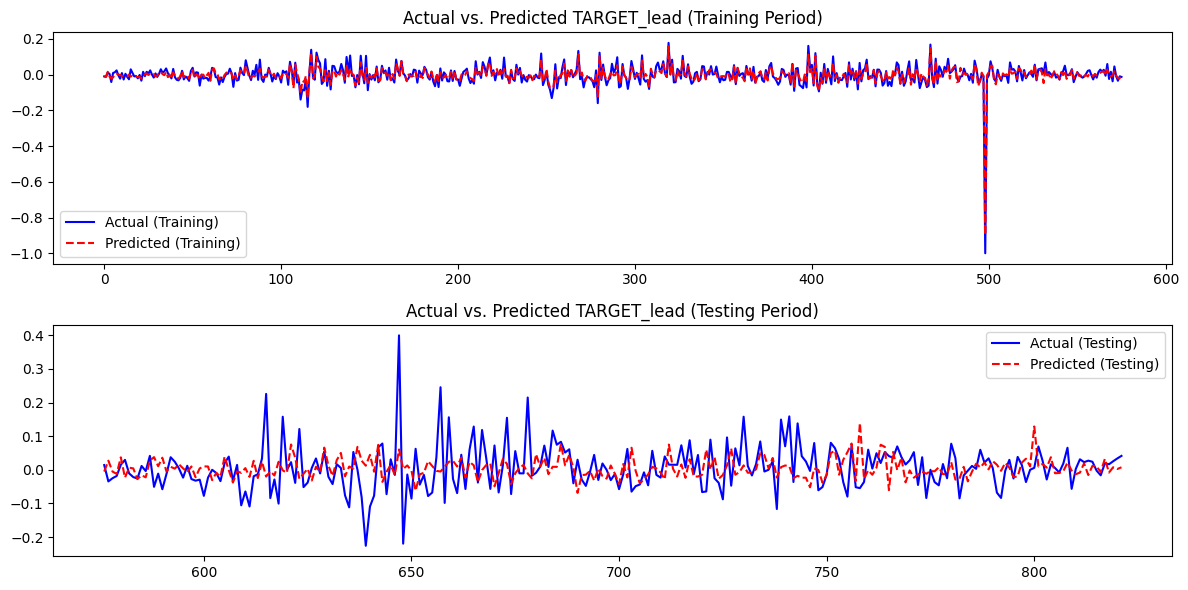

In [97]:
# Plot the actual vs. predicted values for the training and testing periods
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_index_train, y_train_actual, label='Actual (Training)', color='blue')
plt.plot(time_index_train, y_train_pred, label='Predicted (Training)', linestyle='--', color='red')
plt.title('Actual vs. Predicted TARGET_lead (Training Period)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_index_test, y_test_actual, label='Actual (Testing)', color='blue')
plt.plot(time_index_test, y_test_pred, label='Predicted (Testing)', linestyle='--', color='red')
plt.title('Actual vs. Predicted TARGET_lead (Testing Period)')
plt.legend()

plt.tight_layout()
plt.show()